In [1]:
%run -m celldom.nb.logging

In [2]:
import os
import os.path as osp
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pandas as pd
from celldom.core import cytometry
from celldom.config import experiment_config
from celldom.dataset import marker_dataset
from celldom.extract import NO_IMAGES, ALL_IMAGES, APT_IMAGES
import celldom
plt.gray()
None

In [3]:
config = experiment_config.ExperimentConfig(celldom.get_config('experiment', 'exp-20181018-MLadder-Control'))

In [4]:
config.field_names

['datetime', 'apartment', 'prefix', 'street']

In [5]:
config.path_regex

'.*/.*/(?P<prefix>BF)_ST_(?P<street>[0-9]{3})_APT_(?P<apartment>[0-9]{3})_(?P<datetime>[0-9]{14}).tif'

In [6]:
config.parse_path('/data/20181017-Mladder-MOLM-Day0-Chip5/BF_ST_030_APT_028_20181017140706.tif')

{'apartment': '028',
 'datetime': Timestamp('2018-10-17 14:07:06'),
 'prefix': 'BF',
 'street': '030'}

In [7]:
import imp
imp.reload(cytometry)

<module 'celldom.core.cytometry' from '/lab/repos/celldom/python/source/celldom/core/cytometry.py'>

In [8]:
output_dir = '/tmp/test'
if osp.exists(output_dir):
    !rm -rf /tmp/test/*
cytometer = cytometry.Cytometer(config, output_dir)

In [9]:
cytometer.initialize()

Using TensorFlow backend.


In [11]:
img_path = '20181017-Mladder-MOLM-Day0-Chip5/BF_ST_030_APT_004_20181017140449.tif'
img_path = osp.join(celldom.get_data_dir(), 'dataset', 'dataset07', img_path)
img_path

'/lab/data/celldom/dataset/dataset07/20181017-Mladder-MOLM-Day0-Chip5/BF_ST_030_APT_004_20181017140449.tif'

In [12]:
img_raw = io.imread(img_path)
img_raw.dtype, img_raw.shape

(dtype('uint16'), (1024, 1376))

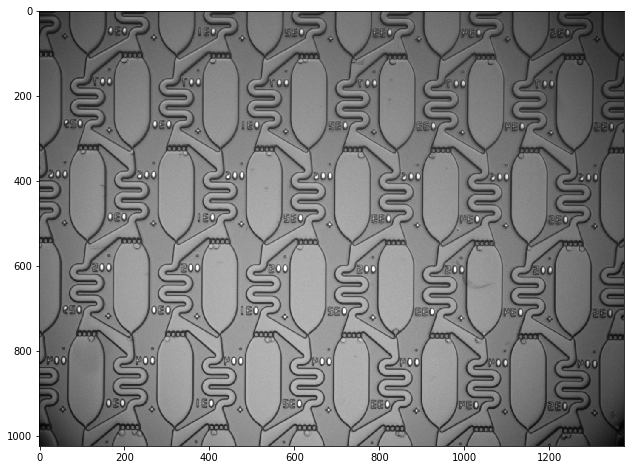

In [15]:
plt.imshow(img_raw)
plt.gcf().set_size_inches(12, 8)

In [16]:
acq = cytometry.Acquisition(config, img_path)

In [17]:
img = acq.load_image()
img.dtype, img.shape

(dtype('uint8'), (1024, 1376, 3))

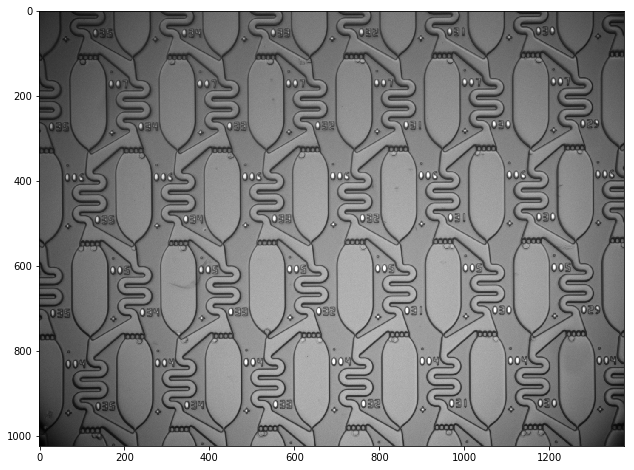

In [19]:
plt.imshow(img)
plt.gcf().set_size_inches(12, 8)

In [20]:
#cytometer.marker_model.config.display()

In [21]:
%%time
#acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=NO_IMAGES)
acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=ALL_IMAGES)
#acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=APT_IMAGES)

CPU times: user 7.03 s, sys: 4.01 s, total: 11 s
Wall time: 10.6 s


In [31]:
cytometer.save(acq_data, apt_data, cell_data)

In [32]:
cytometer.datastore.store.flush()
cytometer.images.store.flush()

In [22]:
acq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
acq_apartment             1 non-null object
acq_datetime              1 non-null datetime64[ns]
acq_id                    1 non-null object
acq_prefix                1 non-null object
acq_processed_at          1 non-null datetime64[ns]
acq_street                1 non-null object
apt_count                 1 non-null int64
raw_image_path            1 non-null object
raw_image_shape_height    1 non-null int64
raw_image_shape_width     1 non-null int64
raw_norm_image            1 non-null object
rotation                  1 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 176.0+ bytes


In [23]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 38 columns):
acq_apartment             6 non-null object
acq_datetime              6 non-null datetime64[ns]
acq_id                    6 non-null object
acq_prefix                6 non-null object
acq_processed_at          6 non-null datetime64[ns]
acq_street                6 non-null object
apt_id                    6 non-null int64
apt_image                 6 non-null object
apt_image_height          6 non-null int64
apt_image_width           6 non-null int64
apt_num                   6 non-null object
apt_num_digit_images      6 non-null object
apt_num_digit_scores      6 non-null object
apt_num_image             6 non-null object
cell_area_mean            0 non-null float64
cell_area_p10             0 non-null float64
cell_area_p50             0 non-null float64
cell_area_p90             0 non-null float64
cell_area_std             0 non-null float64
cell_count                6 non-null int64
ce

In [24]:
acq_data.rotation

0   -0.412193
Name: rotation, dtype: float64

In [25]:
#plt.imshow(acq_data.raw_norm_image.iloc[0])

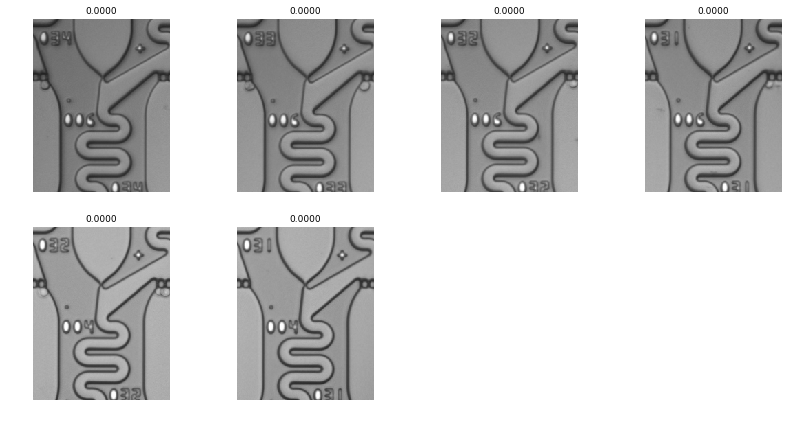

In [26]:
from cvutils.visualize import display_images
display_images(apt_data['apt_image'], titles=['{:.4f}'.format(v) for v in apt_data['occupancy_chamber']])

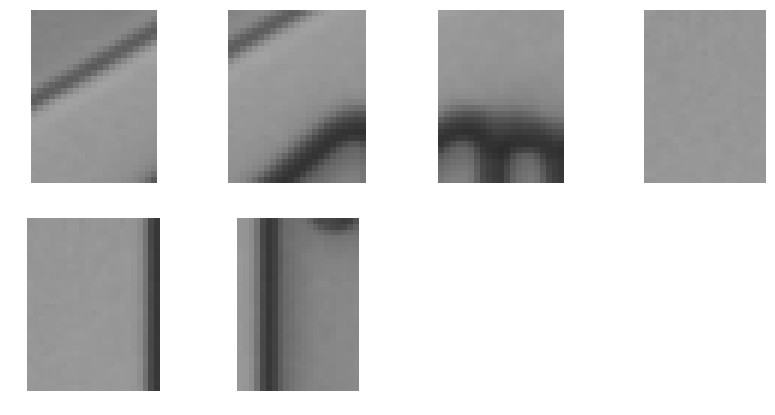

In [27]:
row = apt_data.iloc[1]
display_images(row['apt_num_digit_images'] + row['st_num_digit_images'])

In [39]:
row.filter(regex='scores')

apt_num_digit_scores    1.000,1.000
st_num_digit_scores     1.000,1.000
Name: 1, dtype: object

In [40]:
apt_data[['apt_num','st_num','cell_count']]

,apt_num,st_num,cell_count
0,35,11,0
1,35,10,0
2,35,09,0
3,34,10,0
4,34,09,0
5,34,11,0


In [26]:
from skimage import transform, exposure
#img = apt_data.iloc[1]['apt_num_digit_images'][0]
img = apt_data.iloc[1]['st_num_digit_images'][0]
img = transform.resize(img, (32, 32), mode='constant')[np.newaxis]
img = exposure.rescale_intensity(img, out_range=(0, 1))
img.shape

(1, 32, 32, 3)

In [27]:
img.min(), img.max()

(0.0, 1.0)

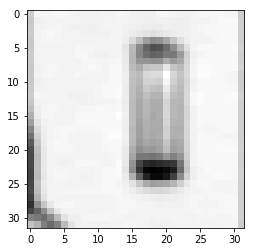

In [28]:
plt.imshow(img[0])

In [29]:
probas = cytometer.digit_model.predict(img)[0]
pd.Series(probas, index=np.arange(0, len(probas))) * 100

0     0.000423
1    36.315708
2     0.082280
3     0.023728
4     0.319999
5     0.001313
6     0.000064
7    63.243492
8     0.012925
9     0.000072
dtype: float32

In [30]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 2
Data columns (total 27 columns):
acq_apartment       17 non-null object
acq_cohort          17 non-null object
acq_color           17 non-null object
acq_condition       17 non-null object
acq_datetime        17 non-null datetime64[ns]
acq_hours           17 non-null object
acq_id              17 non-null object
acq_processed_at    17 non-null datetime64[ns]
acq_pump            17 non-null object
acq_street          17 non-null object
apt_id              17 non-null int64
apt_num             17 non-null object
area                17 non-null int64
cell_id             17 non-null int64
cell_image          0 non-null object
centroid_x          17 non-null float64
centroid_y          17 non-null float64
eccentricity        17 non-null float64
in_chamber          17 non-null bool
in_trap             17 non-null bool
roi_xmax            17 non-null int64
roi_xmin            17 non-null int64
roi_ymax            17 non-null

In [31]:
cell_data.groupby(['in_chamber', 'in_trap']).size()

in_chamber  in_trap
True        False      17
dtype: int64

#### Performance Profiling

In [ ]:
%load_ext line_profiler

In [51]:
from celldom.extract import apartment_extraction
from celldom.extract import cell_extraction
from celldom.extract import marker_extraction

In [52]:
%lprun -f cytometer.analyze -f apartment_extraction.extract -f marker_extraction.extract -f cell_extraction.extract cytometer.analyze(acq, dpf=NO_IMAGES)

Timer unit: 1e-06 s

Total time: 2.56635 s
File: /lab/repos/celldom/python/source/celldom/core/cytometry.py
Function: analyze at line 210

Line #      Hits         Time  Per Hit   % Time  Line Contents
   210                                               def analyze(self, acquisition, dpf=NO_IMAGES):
   211                                                   """Run cytometry analysis on a single acquisition
   212                                           
   213                                                   Args:
   214                                                       acquisition: Acquisition object
   215                                                       dpf: "Data Persistence Flags" indicating how more expensive objects like images are handled; see
   216                                                           celldom.extract for preset groupings of flags that can be used here -- for example:
   217                                                           ```
   218   